because my student id has a 2, so i picked BTC vs MBT pair.


We examine the cross-product spreads and their difference:
- $s^{(1)}_t = \text{BTCZ5} - \text{MBTZ5}$ (Front month cross-product spread)
- $s^{(2)}_t = \text{BTCF6} - \text{MBTF6}$ (Second month cross-product spread)
- $spread\_diff_t = s^{(1)}_t - s^{(2)}_t$ (Spread difference - key metric for deviation analysis)

**Data approach:**
- Load Dec 7-19 data (Dec 7-11 for N-day moving average warm-up)
- All analysis and visualizations use **Dec 12-19 data only**
- N-day rolling averages (1, 3, 5 days) calculated on full data, then filtered

## 1. Setup & Data Loading

In [ ]:
# Install required packages if needed
# !pip install databento pandas numpy matplotlib seaborn scipy statsmodels

# I also saved all those data in /week1_data folder, so you'll need to drag files into this folder to run

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import databento as db
from pathlib import Path
import statsmodels
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11


In [7]:
# Define data directory and date range
DATA_DIR = Path('./week1_data')

# Files for Dec 7-19, 2025 (Dec 7-11 for MA warm-up, Dec 12-19 for analysis)
# Z5 contracts expire on Dec 19 (third Friday)
target_dates = ['20251207', '20251208', '20251209', '20251210', '20251211',
                '20251212', '20251214', '20251215', '20251216', '20251217', '20251218', '20251219']

# Contracts of interest for cross-product spread analysis
MBT_FRONT = 'MBTZ5'   # December 2025 MBT (for front spread)
MBT_SECOND = 'MBTF6'  # January 2026 MBT (for second spread)
BTC_FRONT = 'BTCZ5'   # December 2025 BTC (for front spread)
BTC_SECOND = 'BTCF6'  # January 2026 BTC (for second spread)

TARGET_SYMBOLS = [MBT_FRONT, MBT_SECOND, BTC_FRONT, BTC_SECOND]

print(f"Target contracts: {TARGET_SYMBOLS}")
print(f"Target dates: {target_dates}")
print(f"Note: Dec 7-11 used for N-day MA warm-up; analysis from Dec 12 onward")

Target contracts: ['MBTZ5', 'MBTF6', 'BTCZ5', 'BTCF6']
Target dates: ['20251207', '20251208', '20251209', '20251210', '20251211', '20251212', '20251214', '20251215', '20251216', '20251217', '20251218', '20251219']
Note: Dec 7-11 used for N-day MA warm-up; analysis from Dec 12 onward


In [8]:
# Load all data files
all_data = []

for date in target_dates:
    file_path = DATA_DIR / f'glbx-mdp3-{date}.ohlcv-1m.dbn.zst'
    if file_path.exists():
        data = db.DBNStore.from_file(str(file_path))
        df = data.to_df()
        # Filter for our target symbols only
        df_filtered = df[df['symbol'].isin(TARGET_SYMBOLS)].copy()
        all_data.append(df_filtered)
        print(f"Loaded {date}: {len(df_filtered)} records for target symbols")
    else:
        print(f"File not found: {file_path}")

# Combine all data
df_raw = pd.concat(all_data, ignore_index=False)
df_raw = df_raw.reset_index()
print(f"\nTotal records loaded: {len(df_raw)}")

Loaded 20251207: 140 records for target symbols
Loaded 20251208: 2933 records for target symbols
Loaded 20251209: 3073 records for target symbols
Loaded 20251210: 2777 records for target symbols
Loaded 20251211: 3163 records for target symbols
Loaded 20251212: 2722 records for target symbols
Loaded 20251214: 153 records for target symbols
Loaded 20251215: 3383 records for target symbols
Loaded 20251216: 3073 records for target symbols
Loaded 20251217: 3178 records for target symbols
Loaded 20251218: 3070 records for target symbols
Loaded 20251219: 3399 records for target symbols

Total records loaded: 31064


In [9]:
df_raw.head(10)

,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
0,2025-12-07 23:00:00+00:00,33,1,42038063,90305.0,90305.0,90305.0,90305.0,1,BTCF6
1,2025-12-07 23:00:00+00:00,33,1,42027436,89820.0,89920.0,89800.0,89865.0,7,BTCZ5
2,2025-12-07 23:00:00+00:00,33,1,42129178,89800.0,89915.0,89760.0,89910.0,126,MBTZ5
3,2025-12-07 23:01:00+00:00,33,1,42027436,89945.0,90025.0,89945.0,89965.0,11,BTCZ5
4,2025-12-07 23:01:00+00:00,33,1,42129178,89920.0,90050.0,89885.0,89975.0,137,MBTZ5
5,2025-12-07 23:01:00+00:00,33,1,42038063,90520.0,90520.0,90520.0,90520.0,1,BTCF6
6,2025-12-07 23:02:00+00:00,33,1,42042052,90510.0,90525.0,90510.0,90525.0,5,MBTF6
7,2025-12-07 23:02:00+00:00,33,1,42027436,89885.0,89965.0,89875.0,89940.0,9,BTCZ5
8,2025-12-07 23:02:00+00:00,33,1,42129178,89945.0,89990.0,89885.0,89975.0,73,MBTZ5
9,2025-12-07 23:03:00+00:00,33,1,42042052,90610.0,90610.0,90610.0,90610.0,1,MBTF6


In [10]:
# Check record counts per symbol
print("Records per symbol:")
print(df_raw.groupby('symbol').size())

Records per symbol:
symbol
BTCF6     2662
BTCZ5     9554
MBTF6     5413
MBTZ5    13435
dtype: int64


## 2. Data Preprocessing

In [11]:
# Pivot data to have each symbol as a column, using close prices
df_raw['timestamp'] = pd.to_datetime(df_raw['ts_event'])

# Create pivot table with close prices
df_prices = df_raw.pivot_table(
    index='timestamp',
    columns='symbol',
    values='close',
    aggfunc='last' 
).sort_index()

print(f"Price data shape: {df_prices.shape}")
print(f"\nDate range: {df_prices.index.min()} to {df_prices.index.max()}")
df_prices.head()

Price data shape: (13539, 4)

Date range: 2025-12-07 23:00:00+00:00 to 2025-12-19 21:59:00+00:00


symbol,BTCF6,BTCZ5,MBTF6,MBTZ5
timestamp,,,,
2025-12-07 23:00:00+00:00,90305.0,89865.0,NaN,89910.0
2025-12-07 23:01:00+00:00,90520.0,89965.0,NaN,89975.0
2025-12-07 23:02:00+00:00,NaN,89940.0,90525.0,89975.0
2025-12-07 23:03:00+00:00,NaN,90075.0,90610.0,90015.0
2025-12-07 23:04:00+00:00,NaN,90045.0,NaN,90025.0


In [12]:
# Check for missing values
print("Missing values per column:")
print(df_prices.isnull().sum())
print(f"\nTotal rows: {len(df_prices)}")

Missing values per column:
symbol
BTCF6    10877
BTCZ5     3985
MBTF6     8126
MBTZ5      104
dtype: int64

Total rows: 13539


In [13]:
# forward fill data since we are using the closing price, and some may not get traded. 
df_prices_filled = df_prices.ffill().bfill()

# Calculate cross-product spreads on FULL dataset (Dec 7-19)
# s1_front = BTC front month - MBT front month (BTCZ5 - MBTZ5)
# s2_second = BTC second month - MBT second month (BTCF6 - MBTF6)
df_spreads_all = pd.DataFrame(index=df_prices_filled.index)
df_spreads_all['s1_front'] = df_prices_filled[BTC_FRONT] - df_prices_filled[MBT_FRONT]
df_spreads_all['s2_second'] = df_prices_filled[BTC_SECOND] - df_prices_filled[MBT_SECOND]

# Calculate spread difference (front spread - second spread)
df_spreads_all['spread_diff'] = df_spreads_all['s1_front'] - df_spreads_all['s2_second']

# Drop any remaining NaN
df_spreads_all = df_spreads_all.dropna()

# Add date/time metadata
df_spreads_all['date'] = df_spreads_all.index.date
df_spreads_all['day_of_week'] = df_spreads_all.index.dayofweek

print(f"Full data shape (Dec 7-19 for MA warm-up): {df_spreads_all.shape}")
print(f"Date distribution (full):\n{df_spreads_all.groupby('date').size()}")

# ============================================================
# FILTER TO DEC 12-19 FOR ALL ANALYSIS AND VISUALIZATION
# Dec 7-11 data is ONLY used for N-day moving average warm-up
# ============================================================
import datetime
ANALYSIS_START_DATE = datetime.date(2025, 12, 12)

df_spreads_display = df_spreads_all[df_spreads_all['date'] >= ANALYSIS_START_DATE].copy()

# Create sequential plot index for stitched visualization (no gaps in x-axis)
df_spreads_display['plot_idx'] = range(len(df_spreads_display))

# Create aliases for consistency with analysis cells
df_spreads_stitched = df_spreads_display.copy()
df_spreads = df_spreads_display[['s1_front', 's2_second', 'spread_diff']].copy()

# Keep full data for rolling average calculation
df_spreads_full = df_spreads_all.copy()

print(f"\n" + "="*60)
print(f"ANALYSIS DATA (Dec 12-19 only):")
print(f"="*60)
print(f"Shape: {df_spreads_display.shape}")
print(f"Date range: {df_spreads_display.index.min()} to {df_spreads_display.index.max()}")
print(f"\nDate distribution:\n{df_spreads_display.groupby('date').size()}")

Full data shape (Dec 7-19 for MA warm-up): (13539, 5)
Date distribution (full):
date
2025-12-07      60
2025-12-08    1368
2025-12-09    1364
2025-12-10    1349
2025-12-11    1342
2025-12-12    1274
2025-12-14      60
2025-12-15    1357
2025-12-16    1367
2025-12-17    1351
2025-12-18    1335
2025-12-19    1312
dtype: int64

ANALYSIS DATA (Dec 12-19 only):
Shape: (8056, 6)
Date range: 2025-12-12 00:00:00+00:00 to 2025-12-19 21:59:00+00:00

Date distribution:
date
2025-12-12    1274
2025-12-14      60
2025-12-15    1357
2025-12-16    1367
2025-12-17    1351
2025-12-18    1335
2025-12-19    1312
dtype: int64


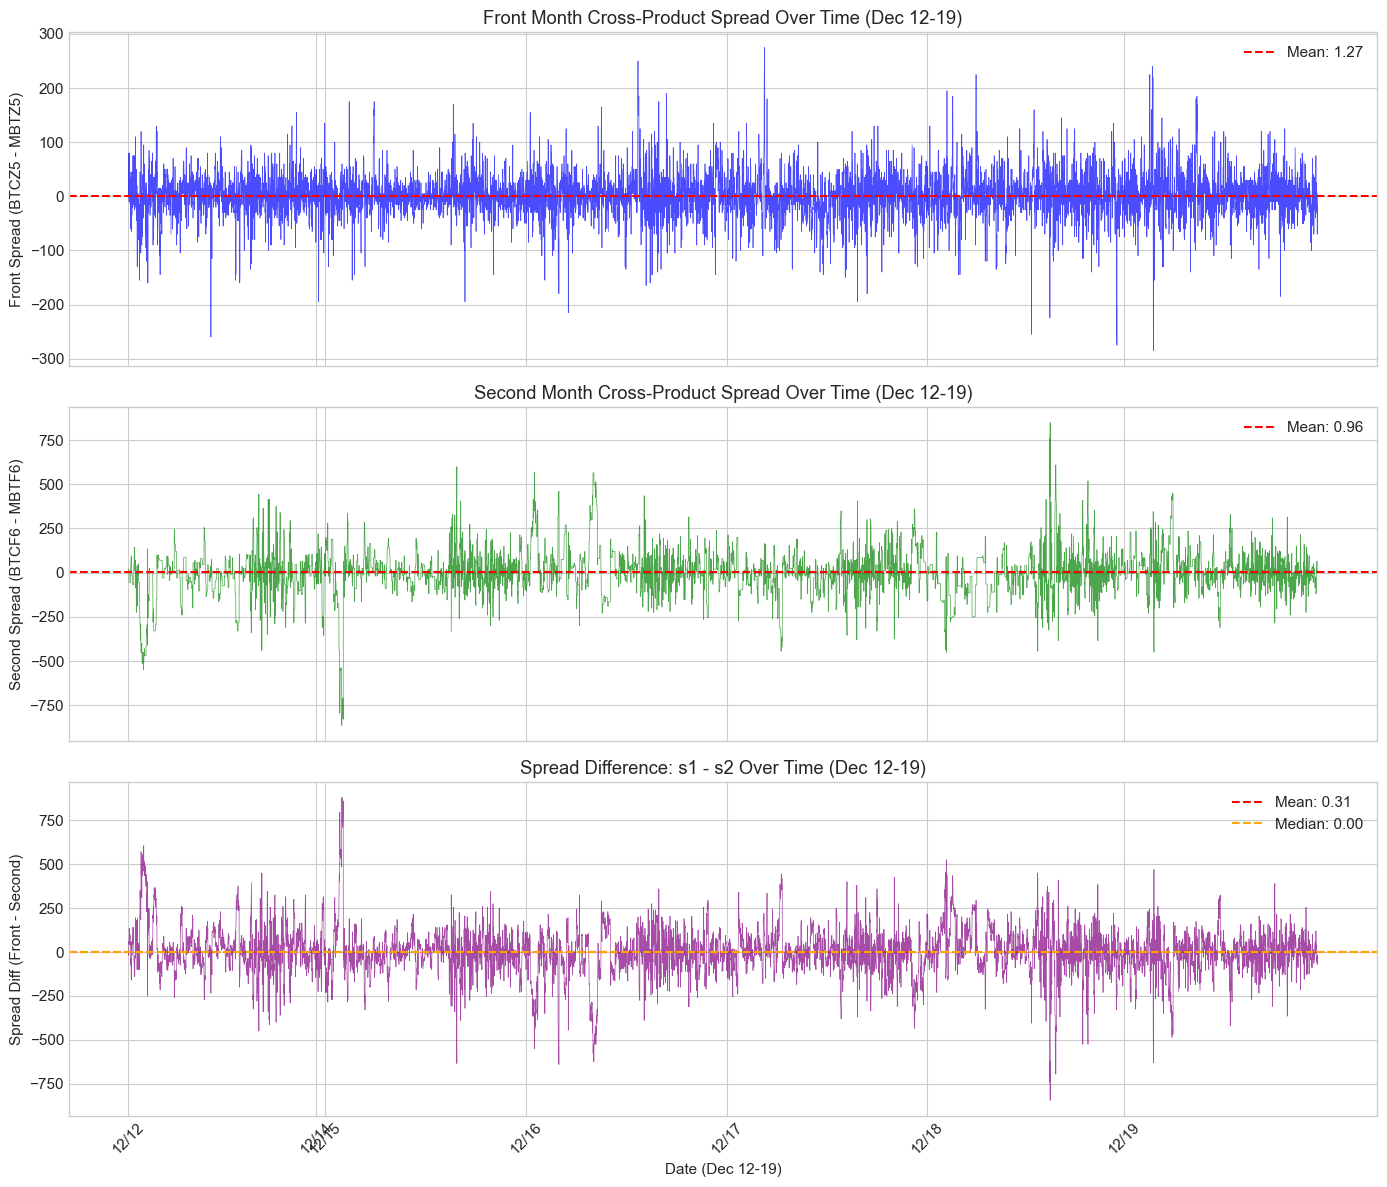

Note: Analysis data is Dec 12-19 only. Dec 7-11 data used only for N-day MA warm-up.


In [14]:
# Quick visualization of spreads (Dec 12-19 only, stitched x-axis)
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

x = df_spreads_stitched['plot_idx']

# Front Spread (s1)
axes[0].plot(x, df_spreads_stitched['s1_front'], color='blue', alpha=0.7, linewidth=0.5)
axes[0].set_ylabel('Front Spread (BTCZ5 - MBTZ5)')
axes[0].set_title('Front Month Cross-Product Spread Over Time (Dec 12-19)')
axes[0].axhline(y=df_spreads_stitched['s1_front'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_spreads_stitched["s1_front"].mean():.2f}')
axes[0].legend()

# Second Spread (s2)
axes[1].plot(x, df_spreads_stitched['s2_second'], color='green', alpha=0.7, linewidth=0.5)
axes[1].set_ylabel('Second Spread (BTCF6 - MBTF6)')
axes[1].set_title('Second Month Cross-Product Spread Over Time (Dec 12-19)')
axes[1].axhline(y=df_spreads_stitched['s2_second'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_spreads_stitched["s2_second"].mean():.2f}')
axes[1].legend()

# Spread Difference
axes[2].plot(x, df_spreads_stitched['spread_diff'], color='purple', alpha=0.7, linewidth=0.5)
axes[2].set_ylabel('Spread Diff (Front - Second)')
axes[2].set_title('Spread Difference: s1 - s2 Over Time (Dec 12-19)')
axes[2].axhline(y=df_spreads_stitched['spread_diff'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_spreads_stitched["spread_diff"].mean():.2f}')
axes[2].axhline(y=df_spreads_stitched['spread_diff'].median(), color='orange', linestyle='--',
                label=f'Median: {df_spreads_stitched["spread_diff"].median():.2f}')
axes[2].legend()

# Create custom x-tick labels showing date transitions
date_changes = df_spreads_stitched.groupby('date')['plot_idx'].first()
tick_positions = date_changes.values
tick_labels = [d.strftime('%m/%d') for d in date_changes.index]

plt.xticks(tick_positions, tick_labels, rotation=45)
plt.xlabel('Date (Dec 12-19)')
plt.tight_layout()
plt.show()

print("Note: Analysis data is Dec 12-19 only. Dec 7-11 data used only for N-day MA warm-up.")

## 3. Descriptive Statistics

In [15]:
# Comprehensive summary statistics for all spreads (Dec 12-19 only)
def compute_summary_stats(series, name):
    """Compute comprehensive summary statistics for a series."""
    stats_dict = {
        'Name': name,
        'Count': len(series),
        'Mean': series.mean(),
        'Median': series.median(),
        'Std Dev': series.std(),
        'Min': series.min(),
        'Max': series.max(),
        'Range': series.max() - series.min(),
        'Skewness': series.skew(),
        'Kurtosis': series.kurtosis(),
        'Q1 (25%)': series.quantile(0.25),
        'Q3 (75%)': series.quantile(0.75),
        'IQR': series.quantile(0.75) - series.quantile(0.25)
    }
    return stats_dict

stats_front = compute_summary_stats(df_spreads['s1_front'], 'Front Spread (BTCZ5-MBTZ5)')
stats_second = compute_summary_stats(df_spreads['s2_second'], 'Second Spread (BTCF6-MBTF6)')
stats_spread_diff = compute_summary_stats(df_spreads['spread_diff'], 'Spread Diff (Front - Second)')

stats_df = pd.DataFrame([stats_front, stats_second, stats_spread_diff]).set_index('Name').T
print("Summary Statistics (Dec 12-19 Data Only):")
print("="*80)
stats_df

Summary Statistics (Dec 12-19 Data Only):


Name,Front Spread (BTCZ5-MBTZ5),Second Spread (BTCF6-MBTF6),Spread Diff (Front - Second)
Count,8056.000000,8056.000000,8056.000000
Mean,1.267999,0.957051,0.310948
Median,0.000000,5.000000,0.000000
Std Dev,41.110927,129.373566,134.765030
Min,-285.000000,-865.000000,-845.000000
Max,275.000000,850.000000,880.000000
Range,560.000000,1715.000000,1725.000000
Skewness,-0.018556,-0.206949,0.112071
Kurtosis,4.767721,5.312428,4.891978
Q1 (25%),-20.000000,-55.000000,-60.000000


In [16]:
# Detailed quantile analysis for all spreads (Dec 12-19 only)
quantiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]

quantile_df = pd.DataFrame({
    'Quantile': [f'{q*100:.0f}%' for q in quantiles],
    'Front Spread': [df_spreads['s1_front'].quantile(q) for q in quantiles],
    'Second Spread': [df_spreads['s2_second'].quantile(q) for q in quantiles],
    'Spread Diff': [df_spreads['spread_diff'].quantile(q) for q in quantiles]
})

print("\nQuantile Analysis (Dec 12-19 Data Only):")
quantile_df


Quantile Analysis (Dec 12-19 Data Only):


,Quantile,Front Spread,Second Spread,Spread Diff
0,1%,-115.00,-382.25,-400.0
1,5%,-65.00,-196.25,-215.0
2,10%,-40.00,-130.00,-140.0
3,25%,-20.00,-55.00,-60.0
4,50%,0.00,5.00,0.0
5,75%,20.00,60.00,60.0
6,90%,45.00,130.00,140.0
7,95%,65.00,205.00,205.0
8,99%,117.25,385.00,395.0


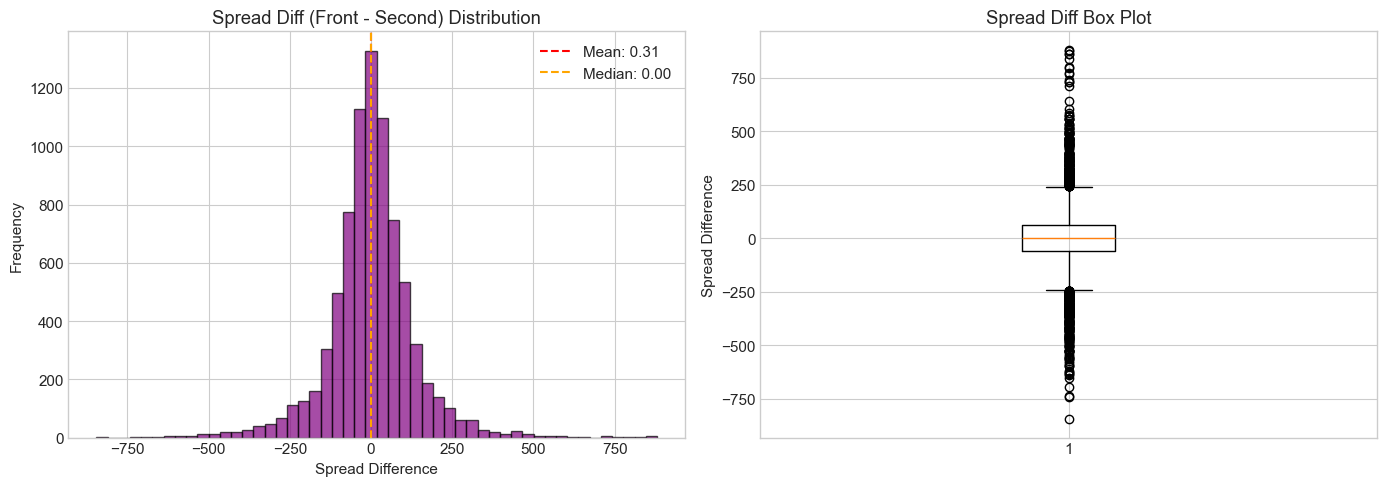

In [17]:
# Distribution plots for spread_diff
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spread Diff Histogram
axes[0].hist(df_spreads['spread_diff'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0].axvline(df_spreads['spread_diff'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_spreads["spread_diff"].mean():.2f}')
axes[0].axvline(df_spreads['spread_diff'].median(), color='orange', linestyle='--', 
                label=f'Median: {df_spreads["spread_diff"].median():.2f}')
axes[0].set_xlabel('Spread Difference')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Spread Diff (Front - Second) Distribution')
axes[0].legend()

# Box Plot
axes[1].boxplot(df_spreads['spread_diff'], vert=True)
axes[1].set_ylabel('Spread Difference')
axes[1].set_title('Spread Diff Box Plot')

plt.tight_layout()
plt.show()

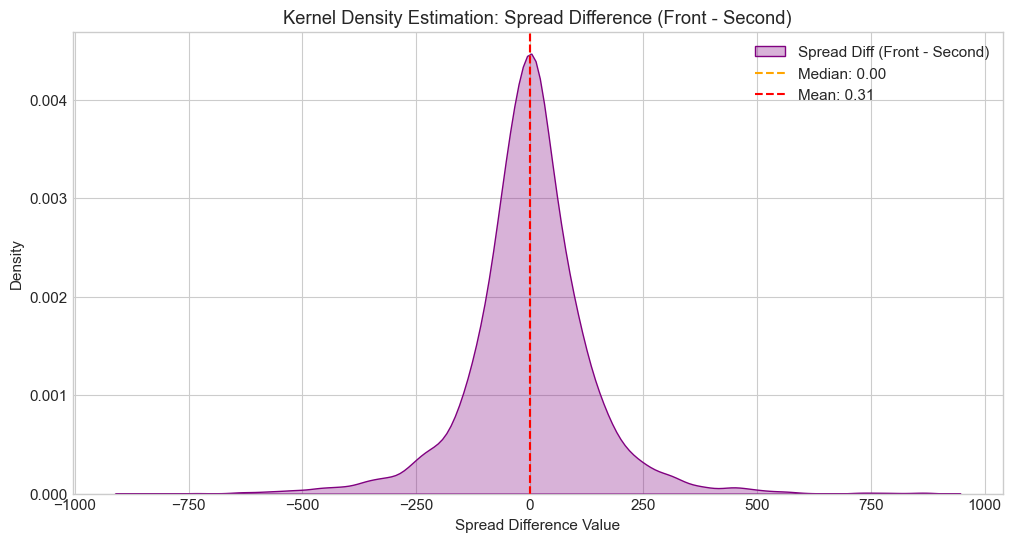

In [18]:
# KDE distribution of spread_diff
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(data=df_spreads['spread_diff'], ax=ax, label='Spread Diff (Front - Second)', 
            color='purple', fill=True, alpha=0.3)

ax.axvline(df_spreads['spread_diff'].median(), color='orange', linestyle='--', 
           label=f'Median: {df_spreads["spread_diff"].median():.2f}')
ax.axvline(df_spreads['spread_diff'].mean(), color='red', linestyle='--',
           label=f'Mean: {df_spreads["spread_diff"].mean():.2f}')

ax.set_xlabel('Spread Difference Value')
ax.set_ylabel('Density')
ax.set_title('Kernel Density Estimation: Spread Difference (Front - Second)')
ax.legend()
plt.show()

## 4. N-Day Rolling Average Analysis

We compute the deviation $d^{(N)}_t = spread\_diff_t - \bar{spread\_diff}_t^{(N)}$ where $\bar{spread\_diff}_t^{(N)}$ is the N-day rolling average of the spread difference (front spread - second spread).

N-day windows based on 23-hour trading day (5pm-4pm with 1hr break) from cme futures:
- 1 day = 1380 minutes
- 3 days = 4140 minutes  
- 5 days = 6900 minutes

In [19]:
# Define N-day rolling windows (in minutes, based on 23-hour trading day)
# Trading day = 23 hours (5pm-4pm with 1hr maintenance break)
MINUTES_PER_TRADING_DAY = 23 * 60  # 1380 minutes

windows = [1 * MINUTES_PER_TRADING_DAY, 3 * MINUTES_PER_TRADING_DAY, 5 * MINUTES_PER_TRADING_DAY]
window_names = ['1day', '3day', '5day']

print(f"N-day windows (in minutes): {dict(zip(window_names, windows))}")

# Calculate rolling averages on FULL dataset (Dec 7-19) for proper warm-up
df_analysis_full = df_spreads_full.copy()

for w, name in zip(windows, window_names):
    # Rolling averages of spread_diff on full data
    df_analysis_full[f'spread_diff_ma_{name}'] = df_analysis_full['spread_diff'].rolling(window=w, min_periods=1).mean()
    
    # Deviations from rolling average
    df_analysis_full[f'd_spread_diff_{name}'] = df_analysis_full['spread_diff'] - df_analysis_full[f'spread_diff_ma_{name}']

# FILTER TO DEC 12-19 FOR ANALYSIS/VISUALIZATION
df_analysis = df_analysis_full[df_analysis_full['date'] >= ANALYSIS_START_DATE].copy()
df_analysis['plot_idx'] = range(len(df_analysis))

print(f"\nRolling averages calculated on full data (Dec 7-19), then filtered to Dec 12-19")
print(f"Analysis data shape: {df_analysis.shape}")
print("\nRolling analysis columns created:")
print([col for col in df_analysis.columns if 'ma' in col or col.startswith('d_')])

N-day windows (in minutes): {'1day': 1380, '3day': 4140, '5day': 6900}

Rolling averages calculated on full data (Dec 7-19), then filtered to Dec 12-19
Analysis data shape: (8056, 12)

Rolling analysis columns created:
['spread_diff_ma_1day', 'd_spread_diff_1day', 'spread_diff_ma_3day', 'd_spread_diff_3day', 'spread_diff_ma_5day', 'd_spread_diff_5day']


In [20]:
# Statistics for deviations d_t^(N) of spread_diff
deviation_stats = []

for w, name in zip(windows, window_names):
    col = f'd_spread_diff_{name}'
    series = df_analysis[col].dropna()
    
    deviation_stats.append({
        'Window': name,
        'Median': series.median(),
        'Std Dev': series.std(),
        'Q5': series.quantile(0.05),
        'Q25': series.quantile(0.25),
        'Q75': series.quantile(0.75),
        'Q95': series.quantile(0.95)
    })

deviation_stats_df = pd.DataFrame(deviation_stats)
print("Deviation Statistics (d_t^(N) = spread_diff - N-day rolling mean):")
print("="*70)
deviation_stats_df

Deviation Statistics (d_t^(N) = spread_diff - N-day rolling mean):


,Window,Median,Std Dev,Q5,Q25,Q75,Q95
0,1day,0.329710,134.360176,-214.281703,-63.526268,64.220109,208.003623
1,3day,-1.651570,134.955885,-215.104771,-64.517814,60.523853,203.876208
2,5day,-2.730471,134.936387,-216.733152,-64.427814,60.030254,203.132790


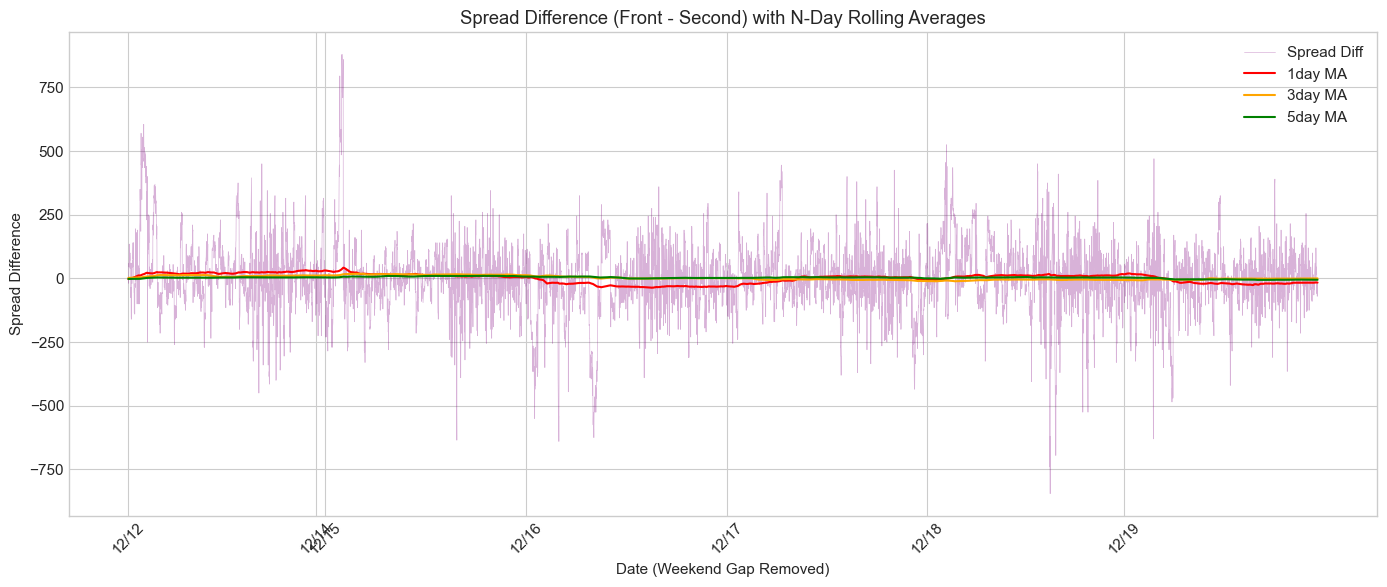

In [21]:
# Visualize spread_diff with N-day rolling averages (weekend stitched)
fig, ax = plt.subplots(figsize=(14, 6))

x = df_analysis['plot_idx']

# Spread diff with rolling averages
ax.plot(x, df_analysis['spread_diff'], alpha=0.3, linewidth=0.5, label='Spread Diff', color='purple')
for w, name, color in zip(windows, window_names, ['red', 'orange', 'green']):
    ax.plot(x, df_analysis[f'spread_diff_ma_{name}'], label=f'{name} MA', color=color, linewidth=1.5)

ax.set_ylabel('Spread Difference')
ax.set_title('Spread Difference (Front - Second) with N-Day Rolling Averages')
ax.legend()

# Custom x-tick labels showing date transitions
date_changes = df_analysis.groupby('date')['plot_idx'].first()
tick_positions = date_changes.values
tick_labels = [d.strftime('%m/%d') for d in date_changes.index]

plt.xticks(tick_positions, tick_labels, rotation=45)
plt.xlabel('Date (Weekend Gap Removed)')
plt.tight_layout()
plt.show()

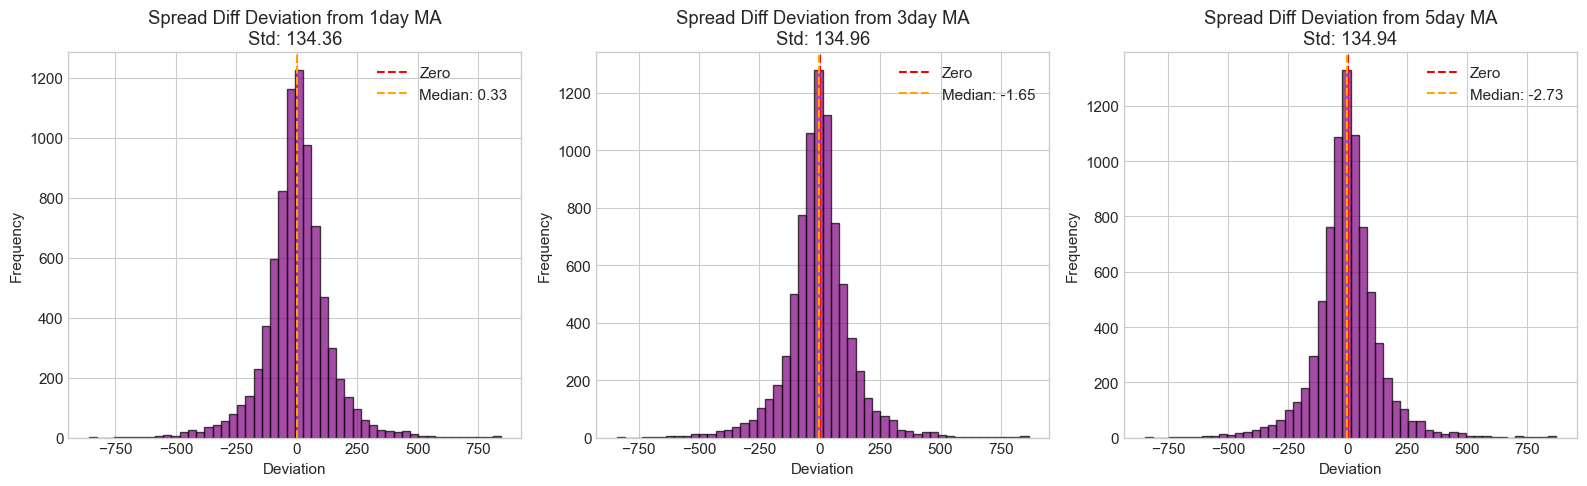

In [22]:
# Deviation distribution plots for spread_diff
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, (w, name) in enumerate(zip(windows, window_names)):
    series = df_analysis[f'd_spread_diff_{name}'].dropna()
    
    axes[i].hist(series, bins=50, color='purple', alpha=0.7, edgecolor='black')
    axes[i].axvline(0, color='red', linestyle='--', label='Zero')
    axes[i].axvline(series.median(), color='orange', linestyle='--', 
                    label=f'Median: {series.median():.2f}')
    axes[i].set_xlabel('Deviation')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Spread Diff Deviation from {name} MA\nStd: {series.std():.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

## 5. Tail Analysis

In [23]:
# Extreme quantile analysis for spread_diff
extreme_quantiles = [0.01, 0.05, 0.10, 0.90, 0.95, 0.99]

tail_analysis = []
for q in extreme_quantiles:
    tail_analysis.append({
        'Quantile': f'{q*100:.0f}%',
        'Value': df_spreads['spread_diff'].quantile(q),
        'Distance from Median': df_spreads['spread_diff'].quantile(q) - df_spreads['spread_diff'].median()
    })

tail_df = pd.DataFrame(tail_analysis)
print("Tail Analysis (Spread Difference = Front - Second):")
tail_df

Tail Analysis (Spread Difference = Front - Second):


,Quantile,Value,Distance from Median
0,1%,-400.0,-400.0
1,5%,-215.0,-215.0
2,10%,-140.0,-140.0
3,90%,140.0,140.0
4,95%,205.0,205.0
5,99%,395.0,395.0


In [24]:
# Identify extreme observations in spread_diff
def find_extremes(series, name, threshold_quantiles=(0.01, 0.99)):
    """Find observations beyond specified quantile thresholds."""
    lower = series.quantile(threshold_quantiles[0])
    upper = series.quantile(threshold_quantiles[1])
    
    extremes_low = series[series < lower]
    extremes_high = series[series > upper]
    
    print(f"\n{name}:")
    print(f"  Lower tail (<{threshold_quantiles[0]*100:.0f}%): {len(extremes_low)} observations below {lower:.2f}")
    print(f"  Upper tail (>{threshold_quantiles[1]*100:.0f}%): {len(extremes_high)} observations above {upper:.2f}")
    return extremes_low, extremes_high

spread_diff_low, spread_diff_high = find_extremes(df_spreads['spread_diff'], 'Spread Difference (Front - Second)')


Spread Difference (Front - Second):
  Lower tail (<1%): 78 observations below -400.00
  Upper tail (>99%): 79 observations above 395.00


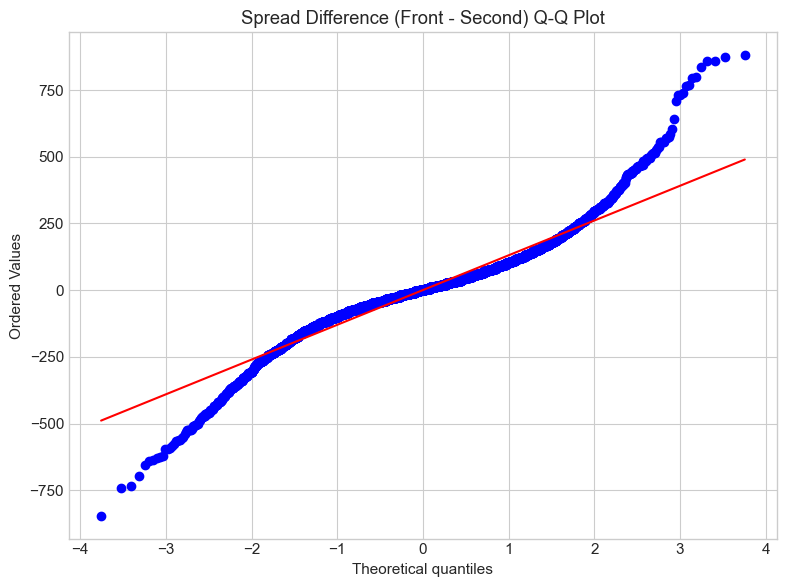


Normality Test (Jarque-Bera):
Spread Difference: JB stat = 8037.44, p-value = 0.0000e+00


In [25]:
# QQ plot to assess normality of spread_diff
fig, ax = plt.subplots(figsize=(8, 6))

stats.probplot(df_spreads['spread_diff'], dist="norm", plot=ax)
ax.set_title('Spread Difference (Front - Second) Q-Q Plot')

plt.tight_layout()
plt.show()

# Normality test
print("\nNormality Test (Jarque-Bera):")
jb_stat, jb_pval = stats.jarque_bera(df_spreads['spread_diff'])
print(f"Spread Difference: JB stat = {jb_stat:.2f}, p-value = {jb_pval:.4e}")

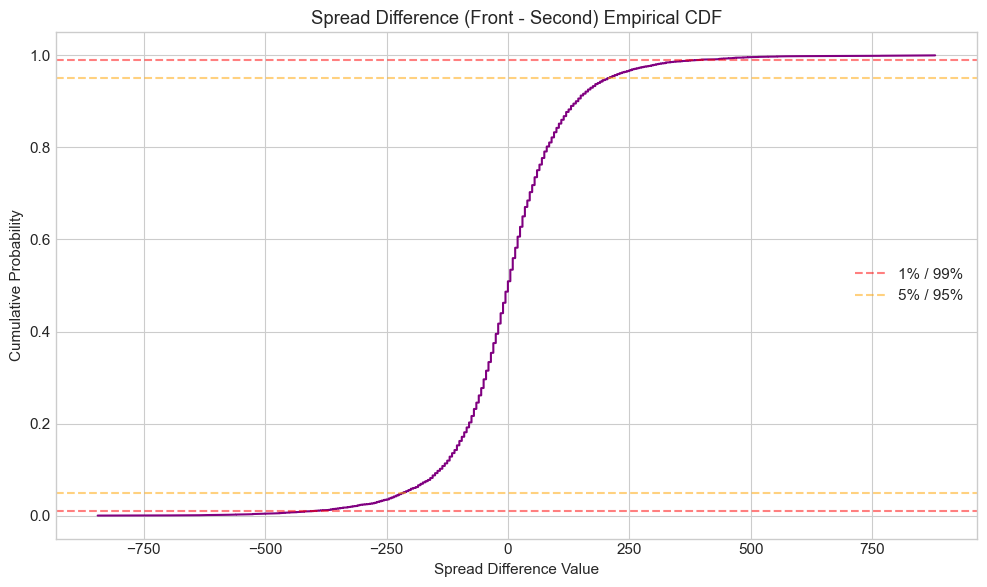

In [26]:
# Tail distribution visualization - Empirical CDF for spread_diff
fig, ax = plt.subplots(figsize=(10, 6))

sorted_data = np.sort(df_spreads['spread_diff'])
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

ax.plot(sorted_data, cdf, color='purple', linewidth=1.5)
ax.axhline(0.01, color='red', linestyle='--', alpha=0.5, label='1% / 99%')
ax.axhline(0.99, color='red', linestyle='--', alpha=0.5)
ax.axhline(0.05, color='orange', linestyle='--', alpha=0.5, label='5% / 95%')
ax.axhline(0.95, color='orange', linestyle='--', alpha=0.5)
ax.set_xlabel('Spread Difference Value')
ax.set_ylabel('Cumulative Probability')
ax.set_title('Spread Difference (Front - Second) Empirical CDF')
ax.legend()

plt.tight_layout()
plt.show()

## 6. Autocorrelation Analysis

Analyze the serial dependence in spread_diff and its deviations from N-day moving averages.

In [41]:
# Autocorrelation at various lags for spread_diff
from statsmodels.stats.stattools import durbin_watson

lags = [1, 5, 10, 30, 60, 120]
print("Autocorrelation of Spread Difference at various lags:")
for lag in lags:
    autocorr = df_spreads['spread_diff'].autocorr(lag=lag)
    print(f"  Lag {lag:>3} min: {autocorr:.4f}")

# Durbin-Watson test for serial correlation
dw = durbin_watson(df_spreads['spread_diff'].diff().dropna())
print(f"\nDurbin-Watson statistic (on changes): {dw:.4f}")
print("(DW ~ 2 indicates no serial correlation; DW < 2 indicates positive autocorrelation)")

Autocorrelation of Spread Difference at various lags:
  Lag   1 min: 0.7711
  Lag   5 min: 0.4609
  Lag  10 min: 0.3255
  Lag  30 min: 0.1094
  Lag  60 min: -0.0059
  Lag 120 min: 0.0101

Durbin-Watson statistic (on changes): 2.5269
(DW ~ 2 indicates no serial correlation; DW < 2 indicates positive autocorrelation)


In [42]:
# Autocorrelation of deviations at various lags
print("Autocorrelation of Deviations from N-day MA at various lags:")
for name in window_names:
    dev_col = f'd_spread_diff_{name}'
    print(f"\n{name} deviation autocorrelation:")
    for lag in [1, 10, 60]:
        autocorr = df_analysis[dev_col].autocorr(lag=lag)
        print(f"  Lag {lag:>3} min: {autocorr:.4f}")

Autocorrelation of Deviations from N-day MA at various lags:

1day deviation autocorrelation:
  Lag   1 min: 0.7699
  Lag  10 min: 0.3220
  Lag  60 min: -0.0098

3day deviation autocorrelation:
  Lag   1 min: 0.7719
  Lag  10 min: 0.3276
  Lag  60 min: -0.0026

5day deviation autocorrelation:
  Lag   1 min: 0.7718
  Lag  10 min: 0.3273
  Lag  60 min: -0.0035


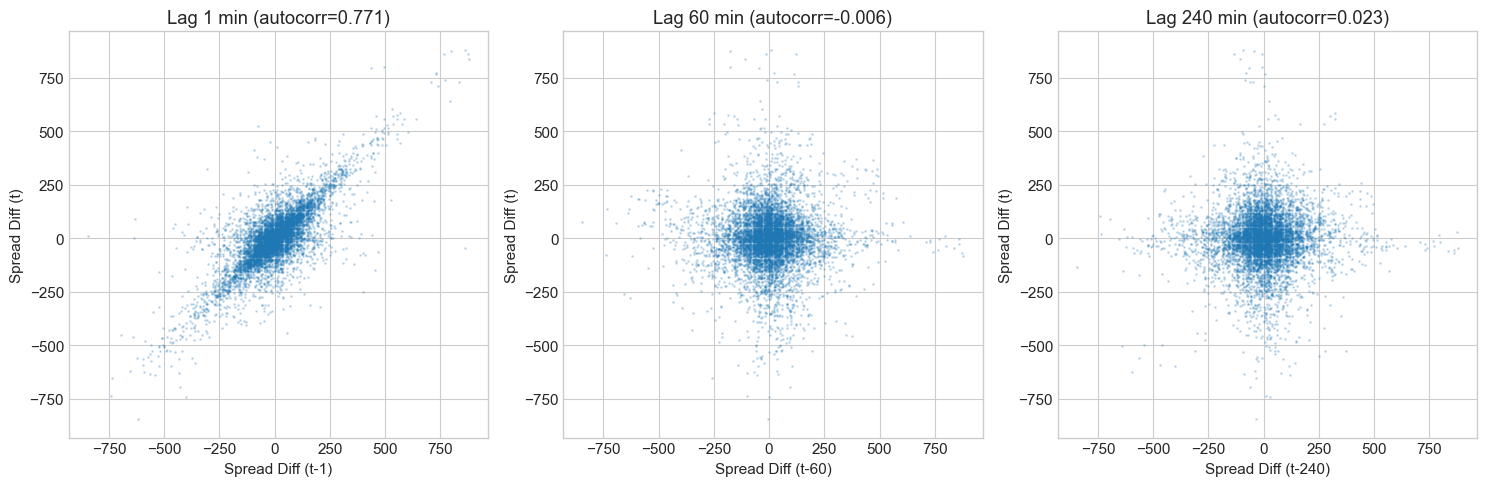

In [43]:
# Scatter plot: spread_diff vs lagged spread_diff
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

lags_to_plot = [1, 60, 240]  # 1 min, 1 hour, 4 hours
for ax, lag in zip(axes, lags_to_plot):
    spread_diff = df_spreads['spread_diff']
    lagged = spread_diff.shift(lag)
    
    # Remove NaN
    valid_idx = ~lagged.isna()
    current = spread_diff[valid_idx]
    lagged_valid = lagged[valid_idx]
    
    autocorr = current.corr(lagged_valid)
    
    ax.scatter(lagged_valid, current, alpha=0.2, s=1)
    ax.set_xlabel(f'Spread Diff (t-{lag})')
    ax.set_ylabel('Spread Diff (t)')
    ax.set_title(f'Lag {lag} min (autocorr={autocorr:.3f})')

plt.tight_layout()
plt.show()

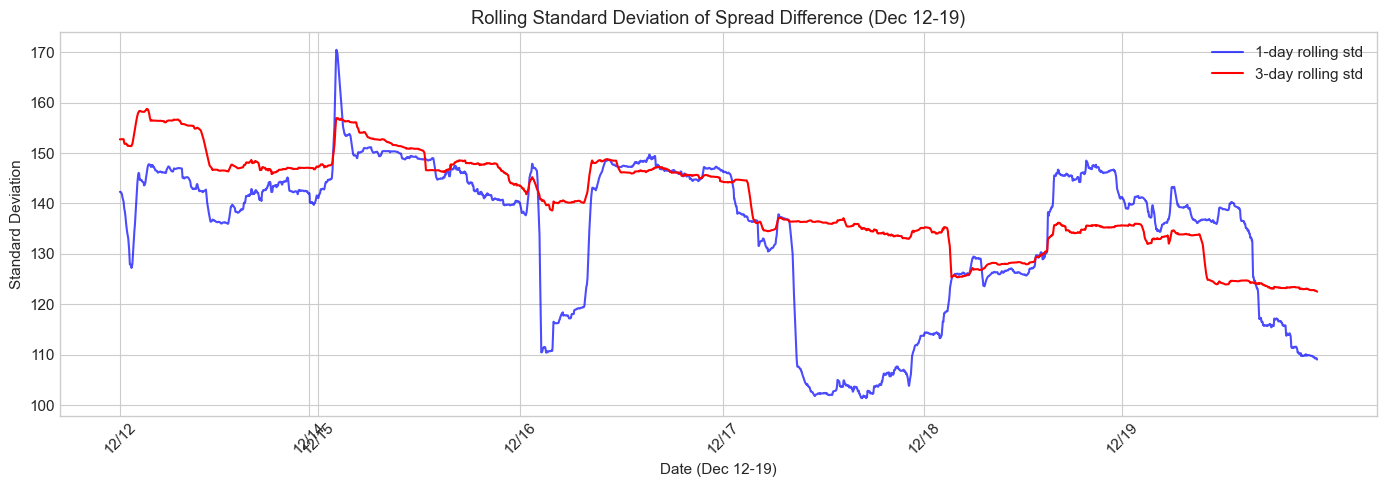

In [45]:
# Rolling standard deviation of spread_diff (calculated on full data, displayed for Dec 12-19)
# Calculate on full data first
rolling_std_1day_full = df_spreads_full['spread_diff'].rolling(window=MINUTES_PER_TRADING_DAY).std()
rolling_std_3day_full = df_spreads_full['spread_diff'].rolling(window=3*MINUTES_PER_TRADING_DAY).std()

# Filter to analysis period
rolling_std_1day = rolling_std_1day_full[df_spreads_full['date'] >= ANALYSIS_START_DATE]
rolling_std_3day = rolling_std_3day_full[df_spreads_full['date'] >= ANALYSIS_START_DATE]

fig, ax = plt.subplots(figsize=(14, 5))

x = df_analysis['plot_idx']
ax.plot(x, rolling_std_1day.values, alpha=0.7, label='1-day rolling std', color='blue')
ax.plot(x, rolling_std_3day.values, label='3-day rolling std', color='red', linewidth=1.5)
ax.set_xlabel('Date (Dec 12-19)')
ax.set_ylabel('Standard Deviation')
ax.set_title('Rolling Standard Deviation of Spread Difference (Dec 12-19)')
ax.legend()

# Custom x-tick labels
date_changes = df_analysis.groupby('date')['plot_idx'].first()
plt.xticks(date_changes.values, [d.strftime('%m/%d') for d in date_changes.index], rotation=45)
plt.tight_layout()
plt.show()

## 7. Time Patterns Analysis

In [44]:
# Add time components (using stitched data)
df_time = df_spreads_stitched.copy()
df_time['hour'] = df_time.index.hour

# Day names for plotting
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

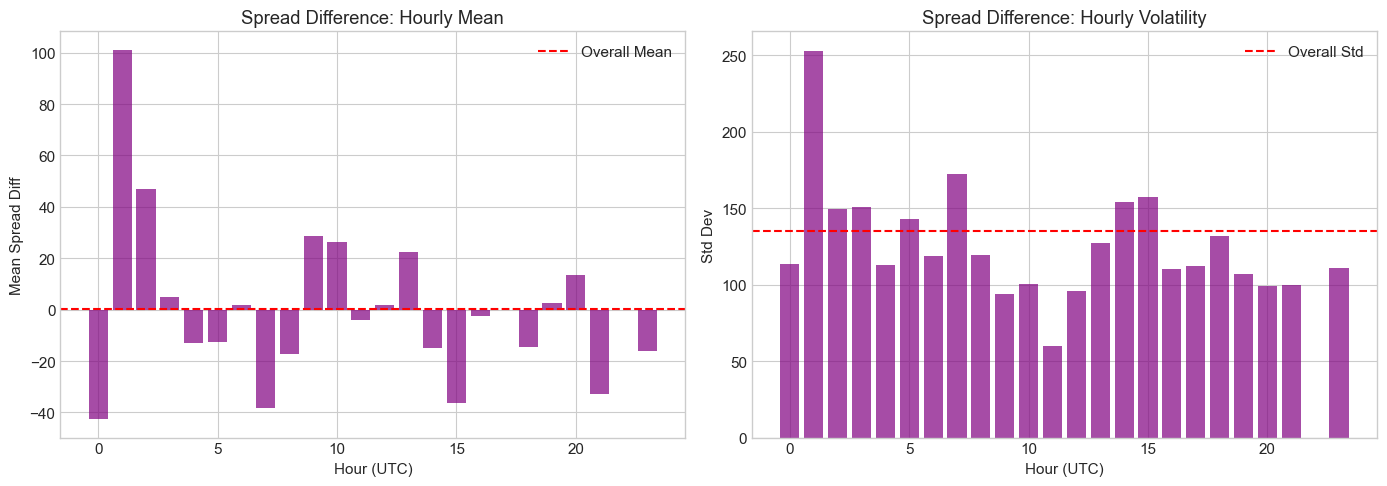

In [46]:
# Intraday patterns (by hour) for spread_diff
hourly_stats = df_time.groupby('hour').agg({
    'spread_diff': ['mean', 'std', 'count']
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spread Diff hourly mean
axes[0].bar(hourly_stats.index, hourly_stats[('spread_diff', 'mean')], color='purple', alpha=0.7)
axes[0].axhline(df_time['spread_diff'].mean(), color='red', linestyle='--', label='Overall Mean')
axes[0].set_xlabel('Hour (UTC)')
axes[0].set_ylabel('Mean Spread Diff')
axes[0].set_title('Spread Difference: Hourly Mean')
axes[0].legend()

# Spread Diff hourly volatility
axes[1].bar(hourly_stats.index, hourly_stats[('spread_diff', 'std')], color='purple', alpha=0.7)
axes[1].axhline(df_time['spread_diff'].std(), color='red', linestyle='--', label='Overall Std')
axes[1].set_xlabel('Hour (UTC)')
axes[1].set_ylabel('Std Dev')
axes[1].set_title('Spread Difference: Hourly Volatility')
axes[1].legend()

plt.tight_layout()
plt.show()

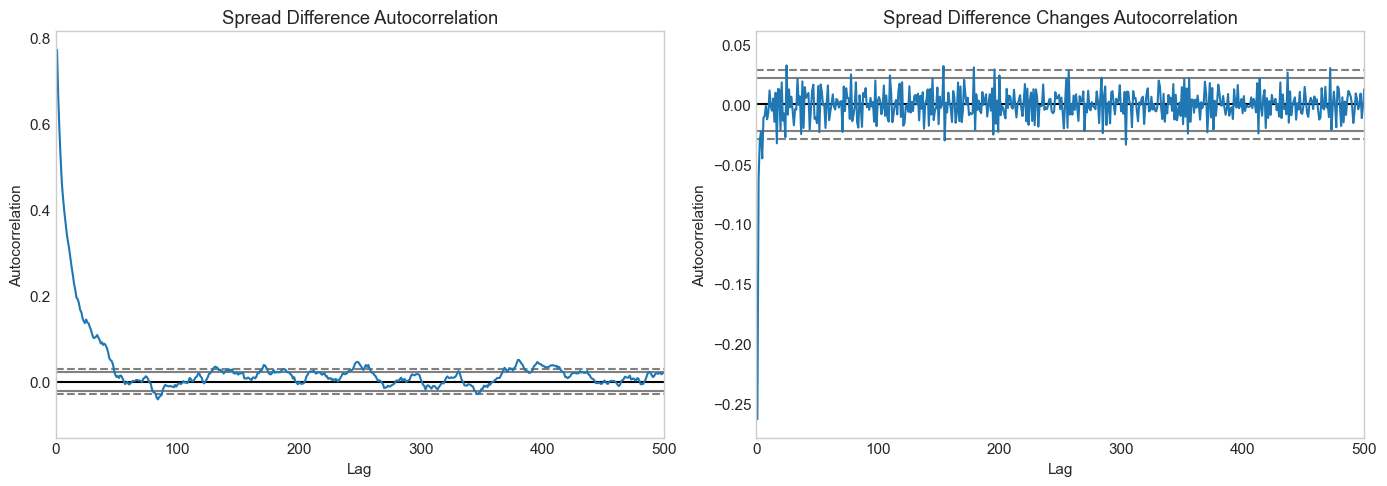

In [48]:
# Autocorrelation analysis (using stitched data)
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spread Diff autocorrelation
pd.plotting.autocorrelation_plot(df_spreads_stitched['spread_diff'], ax=axes[0])
axes[0].set_title('Spread Difference Autocorrelation')
axes[0].set_xlim(0, 500)

# Spread Diff changes autocorrelation
spread_diff_changes = df_spreads_stitched['spread_diff'].diff().dropna()
pd.plotting.autocorrelation_plot(spread_diff_changes, ax=axes[1])
axes[1].set_title('Spread Difference Changes Autocorrelation')
axes[1].set_xlim(0, 500)

plt.tight_layout()
plt.show()

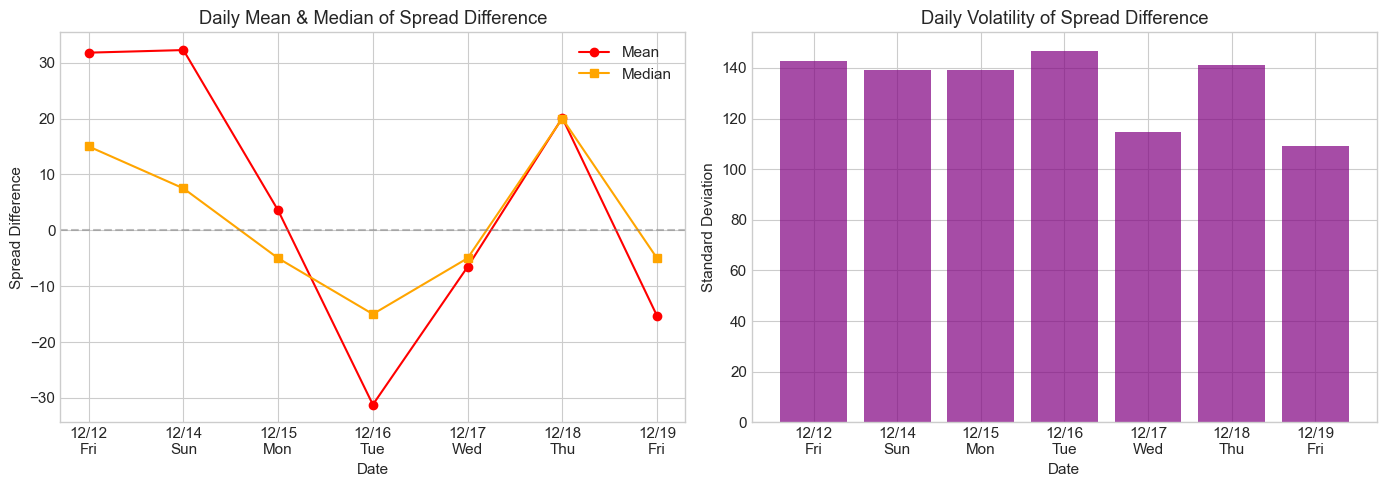

In [49]:
# Daily evolution (using stitched data)
daily_stats_evolution = df_time.groupby('date')['spread_diff'].agg(['mean', 'median', 'std'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = range(len(daily_stats_evolution))

# Mean and Median by day
axes[0].plot(x, daily_stats_evolution['mean'], marker='o', label='Mean', color='red')
axes[0].plot(x, daily_stats_evolution['median'], marker='s', label='Median', color='orange')
axes[0].set_xticks(x)
axes[0].set_xticklabels([d.strftime('%m/%d\n%a') for d in daily_stats_evolution.index], rotation=0)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Spread Difference')
axes[0].set_title('Daily Mean & Median of Spread Difference')
axes[0].legend()
axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)

# Std by day
axes[1].bar(x, daily_stats_evolution['std'], color='purple', alpha=0.7)
axes[1].set_xticks(x)
axes[1].set_xticklabels([d.strftime('%m/%d\n%a') for d in daily_stats_evolution.index], rotation=0)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_title('Daily Volatility of Spread Difference')

plt.tight_layout()
plt.show()

## 8. Summary & Conclusions

In [50]:
# Final summary statistics (Dec 12-19 data only)
print("="*70)
print("SUMMARY: BTC vs MBT Cross-Product Spread Analysis")
print("Data Period: Dec 12-19, 2025 (Dec 7-11 used for N-day MA warm-up only)")
print("="*70)

print(f"\nAnalysis Period: {df_spreads_stitched.index.min()} to {df_spreads_stitched.index.max()}")
print(f"Total observations: {len(df_spreads_stitched):,}")

print("\n--- Front Spread (BTCZ5 - MBTZ5) ---")
print(f"{'Metric':<15} {'Value':>12}")
print("-" * 28)
print(f"{'Mean':<15} {df_spreads['s1_front'].mean():>12.2f}")
print(f"{'Median':<15} {df_spreads['s1_front'].median():>12.2f}")
print(f"{'Std Dev':<15} {df_spreads['s1_front'].std():>12.2f}")

print("\n--- Second Spread (BTCF6 - MBTF6) ---")
print(f"{'Metric':<15} {'Value':>12}")
print("-" * 28)
print(f"{'Mean':<15} {df_spreads['s2_second'].mean():>12.2f}")
print(f"{'Median':<15} {df_spreads['s2_second'].median():>12.2f}")
print(f"{'Std Dev':<15} {df_spreads['s2_second'].std():>12.2f}")

print("\n--- Spread Difference (Front - Second) ---")
print(f"{'Metric':<15} {'Value':>12}")
print("-" * 28)
print(f"{'Mean':<15} {df_spreads['spread_diff'].mean():>12.2f}")
print(f"{'Median':<15} {df_spreads['spread_diff'].median():>12.2f}")
print(f"{'Std Dev':<15} {df_spreads['spread_diff'].std():>12.2f}")

print("\n--- Deviation Statistics (from N-day Rolling Mean of Spread Diff) ---")
print(f"{'Window':<10} {'Median':>12} {'Std Dev':>12}")
print("-" * 35)
for name in window_names:
    dev_col = f'd_spread_diff_{name}'
    series = df_analysis[dev_col].dropna()
    print(f"{name:<10} {series.median():>12.4f} {series.std():>12.4f}")

SUMMARY: BTC vs MBT Cross-Product Spread Analysis
Data Period: Dec 12-19, 2025 (Dec 7-11 used for N-day MA warm-up only)

Analysis Period: 2025-12-12 00:00:00+00:00 to 2025-12-19 21:59:00+00:00
Total observations: 8,056

--- Front Spread (BTCZ5 - MBTZ5) ---
Metric                 Value
----------------------------
Mean                    1.27
Median                  0.00
Std Dev                41.11

--- Second Spread (BTCF6 - MBTF6) ---
Metric                 Value
----------------------------
Mean                    0.96
Median                  5.00
Std Dev               129.37

--- Spread Difference (Front - Second) ---
Metric                 Value
----------------------------
Mean                    0.31
Median                  0.00
Std Dev               134.77

--- Deviation Statistics (from N-day Rolling Mean of Spread Diff) ---
Window           Median      Std Dev
-----------------------------------
1day             0.3297     134.3602
3day            -1.6516     134.9559
5day  

## Key Findings

The spread difference, defined as $spread\_diff = (BTCZ5 - MBTZ5) - (BTCF6 - MBTF6)$ has some interesting pattersn

**Central Tendency & Dispersion:** The spread difference is centered near zero, with both mean and median close to 0. The standard deviation indicates the typical range of fluctuations around this central value.

**N-Day Deviation Analysis:** We calculated deviations from 1-day, 3-day, and 5-day rolling means using a 23-hour trading day (1380 minutes). The deviation statistics show consistent behavior across all three windows, with median deviations near zero and standard deviations that capture the typical departure from the moving average.

**Distribution Characteristics:** The spread difference distribution shows some deviation from normality with heavier tails than a Gaussian distribution, as evidenced by the Jarque-Bera test results. This suggests occasional large deviations that exceed what would be expected under normal distribution assumptions.

**Mean Reversion:** The high autocorrelation in spread_diff levels, combined with lower autocorrelation in spread_diff changes, suggests mean-reverting behavior around the N-day moving averages. This characteristic is potentially useful for spread trading strategies that exploit temporary deviations from the rolling mean.

**Volatility Pattern:**:  from the hourly chart we can see that: 
  - Lower volatility at hours 10-12 UTC (~60-100) - this is 5-7am CT, quiet pre-US session
  - Higher volatility during US trading hours (13-17 UTC = 8am-12pm CT)
  - mean pattern is mostly noise - dominated by a few outliers.

claude code was helping out. i asked it to do some exploratory analysis based on s1 and s2, also asked it to stitch data on the plot since weekends need to be skipped.